O código abaixo é utilizado para baixar o dataset do Kaggle através do client


In [0]:
''!pip install kaggle

In [0]:
# Import kaggle.json from google drive
# This snippet will output a link which needs authentication from any google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 44.4MB/s]
 98% 5.00M/5.10M [00:00<00:00, 26.0MB/s]
100% 5.10M/5.10M [00:00<00:00, 24.8MB/s]
100% 1.30G/1.30G [00:21<00:00, 69.4MB/s]
100% 1.30G/1.30G [00:21<00:00, 64.4MB/s]
100% 4.97G/4.98G [02:43<00:00, 27.5MB/s]
100% 4.98G/4.98G [02:43<00:00, 32.7MB/s]


In [0]:
!unzip -q train.zip -d img


Aqui começa a análise dos dados do dataset do Kaggle

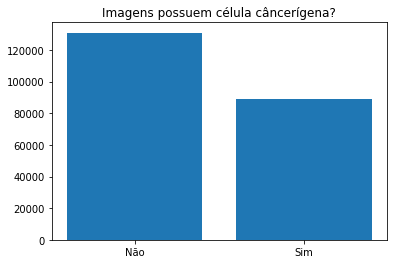

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

data = pd.read_csv('train_labels.csv');

data.rename(columns={'label': 'Cancer'}, inplace=True)



dataGrouped = data.groupby('Cancer')
dfFinal = dataGrouped.size().reset_index(name='Size')
dfFinal.replace([0,1],['Não','Sim'], inplace=True)

plt.bar(dfFinal['Cancer'],dfFinal['Size'])
plt.title('Imagens possuem célula câncerígena?')
plt.show()


Pegar exemplos de imagens que não possuem câncer:

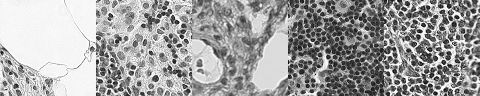

In [0]:
img = None
i = 1
for index, row in data[data.Cancer == 0].iterrows():
  
  filepath = 'img/'+row['id']+'.tif'

  newImg = cv2.imread(filepath)
  img = newImg if img is None else cv2.hconcat([img,newImg])

  if i == 5:
    break
  else:
    i +=1
cv2_imshow(img)

In [0]:
Pegar exemplos de imagens que possuem câncer:

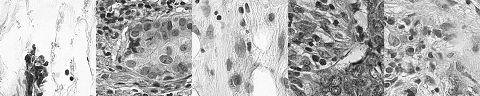

In [0]:
img = None
i = 1
for index, row in data[data.Cancer == 1].iterrows():
  
  filepath = 'img/'+row['id']+'.tif'
  
  newImg = cv2.imread(filepath)
  img = newImg if img is None else cv2.hconcat([img,newImg])
  
  if i == 5:
    break
  else:
    i +=1
cv2_imshow(img)

In [0]:
for index, row in data.iterrows():
  filepath = 'img/'+row['id']+'.tif'
  image = cv2.imread(filepath)
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(filepath, grayImage)

In [0]:
!rm -rf sample_data/

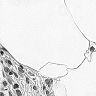

In [0]:
for index, row in data.iterrows():
  img = cv2.imread('img/'+row['id']+'.tif')
  cv2_imshow(img)
  break;

In [0]:
X_train = []
X_test = []
Y_train = []
Y_test = []
for index, row in data.iterrows():
  img = cv2.imread('img/'+row['id']+'.tif')
  if index <= 15400:
    X_train.append(img)
    Y_train.append(data['Cancer'])
  else:
    X_test.append(img)
    Y_test.append(data['Cancer'])
  


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_train = to_categorical(Y_test)

model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(96,96,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
          
model.compile(optimizer='adam', loss='categorical_crossentopy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

In [0]:
!rm -rf train.zip